<h1> Full Width at Half Maximum Biomarkers in Lung MRI Imaging </h1>
<h3>Dataset: 12 phase registered image </h3>

In [1]:
%matplotlib notebook
import numpy as np
import nibabel as nib
import sigpy.plot as pl
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import lagrange
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths
from numpy.polynomial.polynomial import Polynomial

<h1> Loading the data...<h1>

In [2]:
#Load registered image
registered = nib.load("result_nomask.nii")
registered = np.array(registered.dataobj)

In [3]:
#Load lung mask 
mask = nib.load("lung_mask_close.nii")
mask = np.array(mask.dataobj)

In [4]:
#Multiply lung mask with registered image 
registered_mask = np.empty((208, 128, 160, 12))
for i in range(12):
    registered_mask[:,:,:,i] = np.multiply(registered[:,:,:,i], mask[:,:,:,i])

In [5]:
#Rearange the lung respiration phases to: inspiration, exhalation, then inspiration
registered_mask = np.append(registered_mask[:,:,:,6:], (registered_mask[:,:,:,:6]), axis=3)

<h1>Lung Mask Voxel Sample<h1>

In [6]:
#Generate a voxel sample given a size 
def voxel_sample(img, voxel_size):
    size = voxel_size
    x = img.shape[0] // size
    y = img.shape[1] // size
    z = img.shape[2] // size
    t = img.shape[3]
    sample = np.empty((x,y,z,t))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                for l in range(t):
                    sample[i, j, k, l] = np.mean(img[i*size:(i+1)*size, j*size:(j+1)*size, k*size:(k+1)*size, l:l+1])
    return sample

In [7]:
#Calculate 4 voxel sample
voxel_sample_4 = voxel_sample(registered_mask, 4)

<h1> Gaussian Helper Functions <h1>

In [8]:
#Define gaussian function
def gaussian(x,a,mu,sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

In [22]:
#Plot intensity values with gaussian curve fitting
#Input: An array of intensity values with length of 6
def plot_gaussian_curve_fit(intensity_values):
    time = np.arange(12)
    fitted_x, fitted_y = gaussian_curve_fitting(intensity_values)
    
    fig = plt.figure()
    plt.plot(time, intensity_values, "o", label = "Measured")
    plt.plot(fitted_x, fitted_y, label='Gaussian Curve Fit')
    plt.xticks(time)
    plt.title("Gaussian Curve Fitting")
    plt.xlabel("Time")
    plt.ylabel("Intensity")
    plt.legend()
    plt.show()

In [9]:
#Computes gaussian curve fit polynomial for values in [0,11]
def gaussian_curve_fitting(intensity_values):
    n = 12 #len(intensity_values)
    data = intensity_values
    time = np.arange(12)
    fevsize = 208*128*160*13
    
    mean = sum(data*time)/n
    sigma = np.sqrt(sum(data*(time-mean)**2)/n)
    popt,pcov = curve_fit(gaussian,time,data, maxfev=fevsize)
    fitted_x = np.linspace(0,11,20)
    fitted_y = gaussian(fitted_x,*popt)
    ttp_x = fitted_x[np.argmax(fitted_y)]
          
          
    return fitted_x, fitted_y

In [21]:
#Validate time to peak output of algorithm with displayed image value 
def validate_time_to_peak_gaussian(x, y, intensity_values):
    sample_array = intensity_values[x,16,y,:]
    plot_gaussian_curve_fit(sample_array)
    fitted_x, fitted_y = gaussian_curve_fitting(sample_array)
    ttp_x_value = fitted_x[np.argmax(fitted_y)]

    print("Time to peak value of algorithm: ", ttp_x_value)
    print("Time to peak value of displayed image: ", time_to_peak_gaussian_4[x,16,y])
    print("isSame: ", time_to_peak_gaussian_4[x,16,y] == ttp_x_value)



<h1> Full Width at Half Max with no Curve Fitting<h1>

In [24]:
#Calculate full width half max
def calculate_full_width_half_max(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                    slice_1D = img[i,j,k,:]
                    peaks, _ = find_peaks(slice_1D)
                    results_half = peak_widths(slice_1D, peaks, rel_height=0.5)
                    if results_half[0].size == 0:
                        results_half = 0
                        sample[i, j, k] = results_half
                    else:
                        sample[i, j, k] = results_half[0][0]
    return sample

In [25]:
#Calculate full width half max without curve fitting
fwhm_4 = calculate_full_width_half_max(voxel_sample_4)

<IPython.core.display.Javascript object>


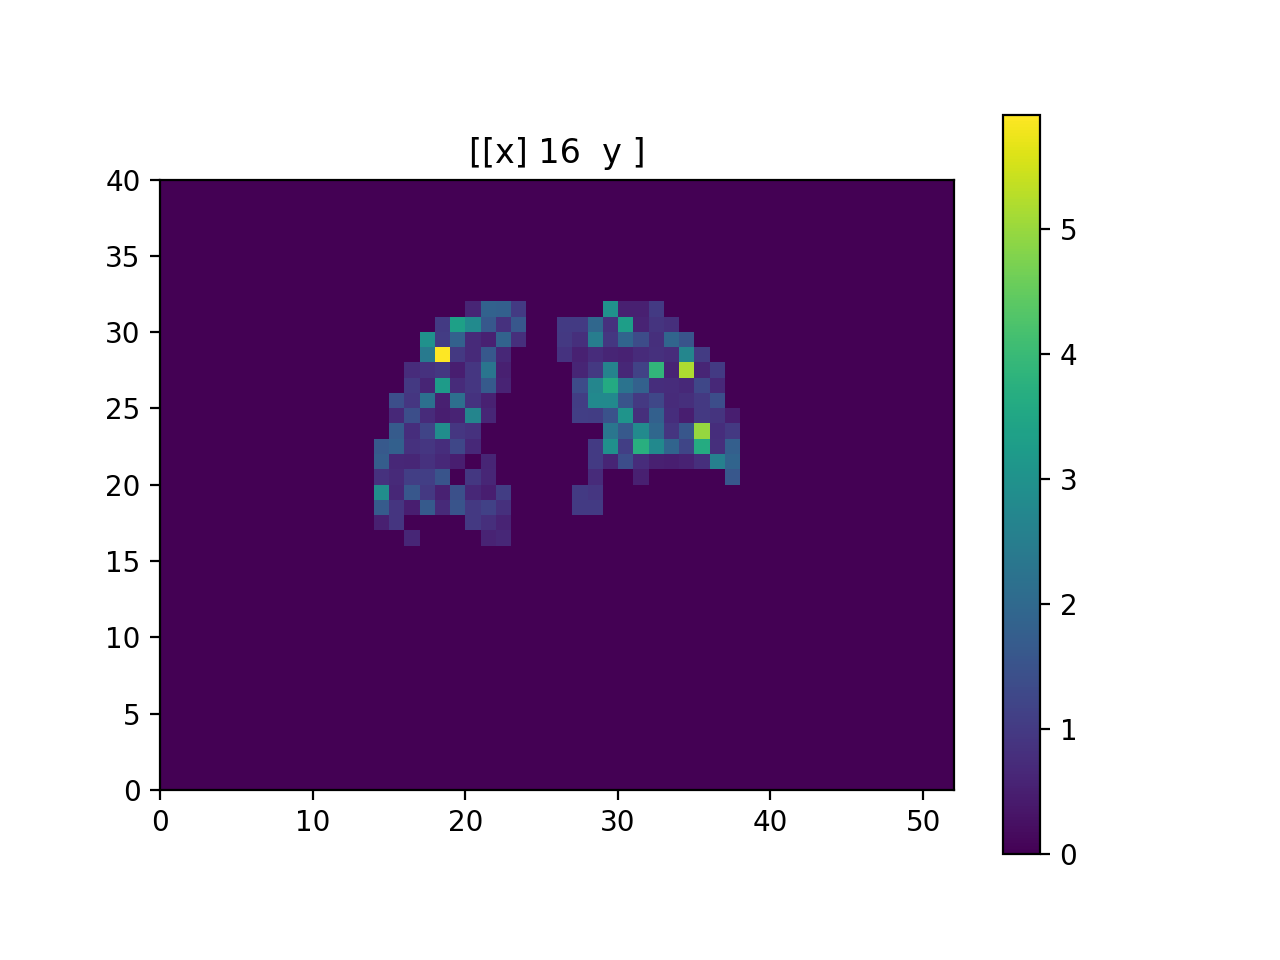

In [26]:
#Plot full width half max of a 4 voxel sample
pl.ImagePlot(fwhm_4, x=0, y=2, colormap ='viridis')

<h1> Full Width at Half Max with Lagrange Curve Fitting<h1>

In [ ]:
#TODO
#Calculate full width half max with lagrange curve fitting
def calculate_full_width_half_max_lagrange(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                    slice_1D = img[i,j,k,:]
                    fitted_x, fitted_y = lagrange_curve_fitting(slice_1D, 20)
                    peaks, _ = find_peaks(fitted_y)
                    results_half = peak_widths(fitted_y, peaks, rel_height=0.5)
                    if results_half[0].size == 0:
                        results_half = 0
                        sample[i, j, k] = results_half
                    else:
                        sample[i, j, k] = results_half[0][0]
    return sample

In [ ]:
#Calculate full width half max with lagrange curve fitting
fwhm_lagrange_4 = calculate_full_width_half_max_lagrange(voxel_sample_4)

In [ ]:
#Plot full width half max of a 4 voxel sample
pl.ImagePlot(fwhm_lagrange_4, x=0, y=2, colormap ='viridis')

<h1> Full Width at Half Max with Gaussian Curve Fitting <h1>

In [12]:
#Calculate full width half max with lagrange curve fitting
#Investigate if np.apply_over_axis or np.apply_along_axis can speed up algorithm 
def calculate_full_width_half_max_gaussian(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                    slice_1D = img[i,j,k,:]
                    fitted_x, fitted_y = gaussian_curve_fitting(slice_1D)
                    peaks, _ = find_peaks(fitted_y)
                    results_half = peak_widths(fitted_y, peaks, rel_height=0.5)
                    if results_half[0].size == 0:
                        results_half = 0
                        sample[i, j, k] = results_half
                    else:
                        sample[i, j, k] = results_half[0][0]
    return sample

In [13]:
#Calculate full width half max with gaussian curve fitting for a 4 sample voxel
fwhm_gaussian_4 = calculate_full_width_half_max_gaussian(voxel_sample_4)

/home/darrenhsu/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


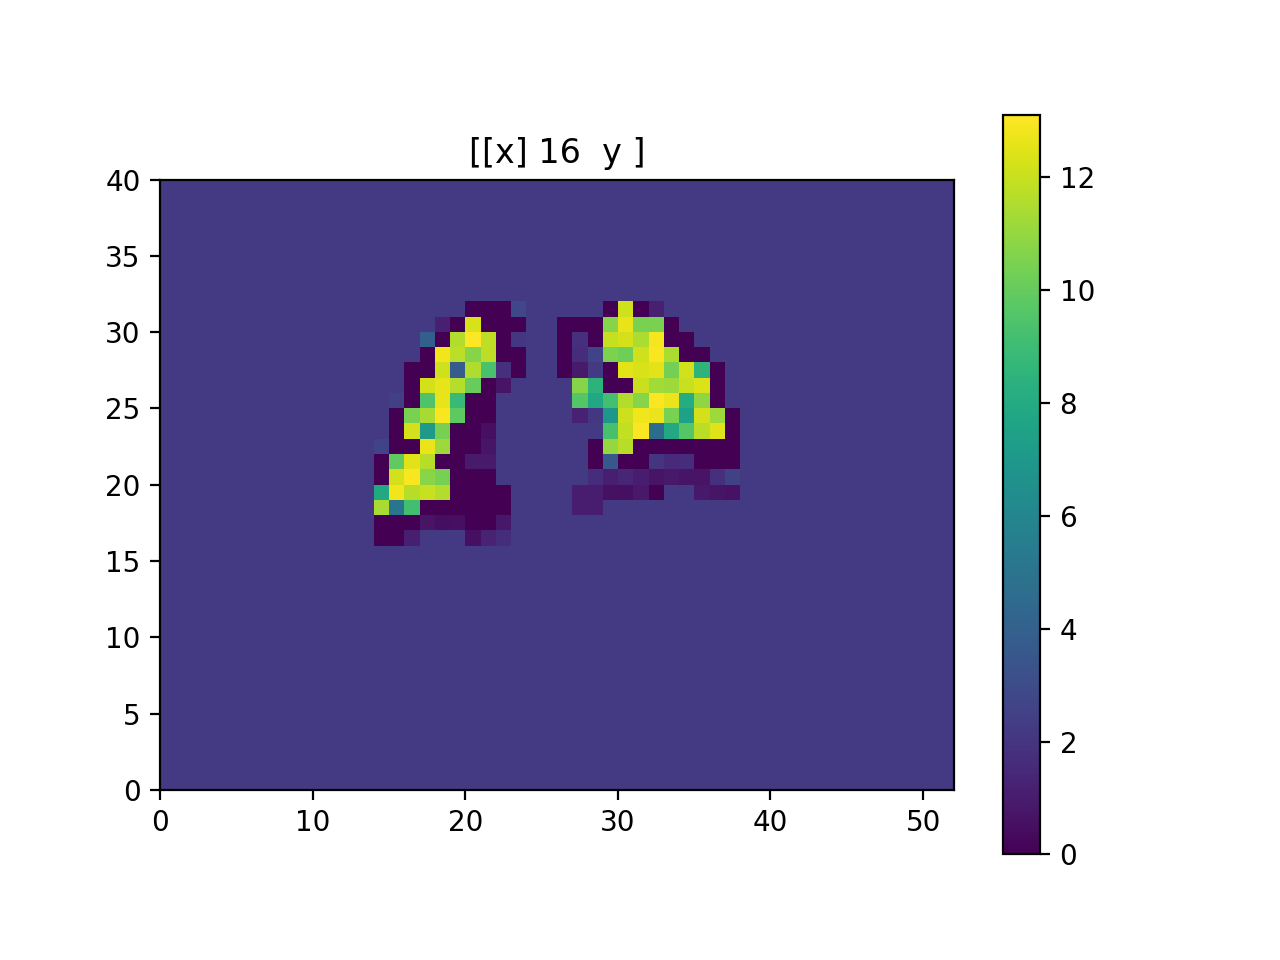

In [15]:
#Plot full width half max of a 4 voxel sample
pl.ImagePlot(fwhm_gaussian_4, x=0, y=2, colormap ='viridis')